# Lab 8: Feature Engineering & Cross-Validation
In this lab, you will practice using `scikit-learn` to do feature engineering and cross-validation to produce a model with low error on held-out data.

In [47]:
# Run this cell to set up your notebook
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
sns.set_context("talk")

from IPython.display import display, Latex, Markdown

### Introduction

For this lab, we will use a toy dataset to predict the house prices in Boston with data provided by the `sklearn.datasets` package. There are more interesting datasets in the package if you want to explore them during your free time!

Run the following cell to load the data. `load_boston()` will return a dictionary object which includes keys for:
- `data` : the features/covariates (X)
- `target` : the response vector (Y)
- `feature_names`: the column names
- `DESCR` : a full description of the data
- `filename`: name of the csv file


In [48]:
from sklearn.datasets import load_boston

boston_data = load_boston()
print(boston_data.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename', 'data_module'])


/Users/jakobnunnendorf/opt/anaconda3/envs/ds310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets includ

In [49]:
boston_data['data']

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [50]:
len(boston_data['data'])

506

In [51]:
print(boston_data['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

A look at the `DESCR` attribute tells us the data contains these features:

    1. CRIM      per capita crime rate by town
    2. ZN        proportion of residential land zoned for lots over 
                 25,000 sq.ft.
    3. INDUS     proportion of non-retail business acres per town
    4. CHAS      Charles River dummy variable (= 1 if tract bounds 
                 river; 0 otherwise)
    5. NOX       nitric oxides concentration (parts per 10 million)
    6. RM        average number of rooms per dwelling
    7. AGE       proportion of owner-occupied units built prior to 1940
    8. DIS       weighted distances to five Boston employment centres
    9. RAD       index of accessibility to radial highways
    10. TAX      full-value property-tax rate per 10,000 USD
    11. PTRATIO  pupil-teacher ratio by town
    12. B        1000(Bk - 0.63)^2 where Bk is the proportion of black 
                 residents by town
    13. LSTAT    % lower status of the population
    
Let's now convert this data into a pandas DataFrame. 

In [52]:
boston = pd.DataFrame(boston_data['data'], columns=boston_data['feature_names'])
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


### Question 1

Let's model this housing price data! Before we can do this, however, we need to split the data into training and test sets. Remember that the response vector (housing prices) lives in the `target` attribute. A random seed is set here so that we can deterministically generate the same splitting in the future if we want to test our result again and find potential bugs.

Use the [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to split out 10% of the data for the test set. Call the resulting splits `X_train`, `X_test`, `Y_train`, `Y_test`.

<!--
BEGIN QUESTION
name: q1
-->

In [53]:
from sklearn.model_selection import train_test_split
np.random.seed(47)
# Do not change the above code

X = boston
Y = pd.Series(boston_data['target'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

### Question 2

As a warmup, fit a linear model to describe the relationship between the housing price and all available features. We've imported `sklearn.linear_model` as `lm`, so you can use that instead of typing out the whole module name. Fill in the cells below to fit a linear regression model to the covariates and create a scatter plot for our predictions vs. the true prices.

<!--
BEGIN QUESTION
name: q2
-->

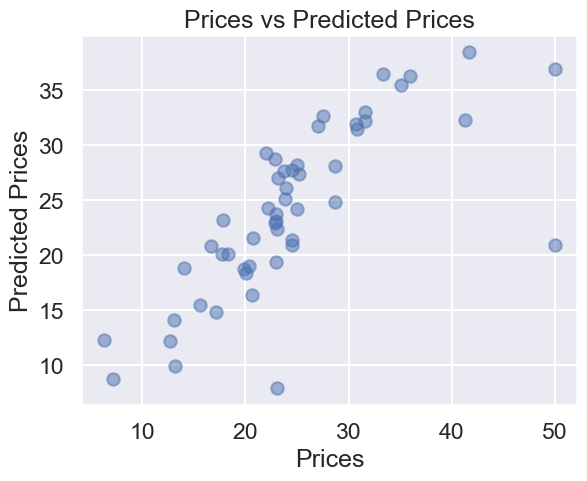

In [54]:
import sklearn.linear_model as lm

linear_model = lm.LinearRegression()

# Fit your linear model
linear_model.fit(X_train, Y_train)

# Predict housing prices on the test set
Y_pred = linear_model.predict(X_test)

# Plot predicted vs true prices
plt.scatter(Y_test, Y_pred, alpha=0.5)
plt.xlabel("Prices")
plt.ylabel("Predicted Prices")
plt.title("Prices vs Predicted Prices");

Briefly analyze the scatter plot above. Do you notice any outliers? Write your answer in the cell below.

There are two that are significantly more expensive than predicted.

### Question 3

As we find from the scatter plot, our model is not perfect. If it were perfect, we would see the identity line (i.e. a line of slope 1). Compute the root mean squared error (RMSE) of the predicted responses: 

$$
\textbf{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^n \left( y_i - \hat{y}_i \right)^2 }
$$

Fill out the function below and compute the RMSE for our predictions on both the training data `X_train` and the test set `X_test`.  Your implementation **should not** use for loops.

<!--
BEGIN QUESTION
name: q3
-->

In [55]:
def rmse(actual_y, predicted_y):
    """
    Args:
        predicted_y: an array of the prediction from the model
        actual_y: an array of the groudtruth label
        
    Returns:
        The root mean square error between the prediction and the groundtruth
    """
    return np.sqrt(np.mean((actual_y - predicted_y)**2))

train_error = rmse(Y_train, linear_model.predict(X_train))
test_error = rmse(Y_test, linear_model.predict(X_test))

print("Training RMSE:", train_error)
print("Test RMSE:", test_error)

Training RMSE: 4.562305960933931
Test RMSE: 5.8870734777578


Is your training error lower than the test error? If so, why could this be happening? Answer in the cell below.

Maybe the training data has errors or more accurately has random fluctuations and by overfitting the model to that data, it performs well on training data but doesn't do well on the test data because it doesn't actually capture the underlying pattern but the noise of the training data. 

## Overfitting

Sometimes we can get even higher accuracy by adding more features. For example, the code below adds the square, square root, and hyperbolic tangent of every feature to the design matrix. We've chosen these bizarre features specifically to highlight overfitting.

In [56]:
boston_with_extra_features = boston.copy()
for feature_name in boston.columns:
    boston_with_extra_features[feature_name + "^2"] = boston_with_extra_features[feature_name] ** 2
    boston_with_extra_features["sqrt" + feature_name] = np.sqrt(boston_with_extra_features[feature_name])
    boston_with_extra_features["tanh" + feature_name] = np.tanh(boston_with_extra_features[feature_name])
    
boston_with_extra_features.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,...,tanhTAX,PTRATIO^2,sqrtPTRATIO,tanhPTRATIO,B^2,sqrtB,tanhB,LSTAT^2,sqrtLSTAT,tanhLSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,...,1.0,234.09,3.911521,1.0,157529.6100,19.922349,1.0,24.8004,2.231591,0.999905
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,...,1.0,316.84,4.219005,1.0,157529.6100,19.922349,1.0,83.5396,3.023243,1.000000
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,...,1.0,316.84,4.219005,1.0,154315.4089,19.819939,1.0,16.2409,2.007486,0.999368
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,...,1.0,349.69,4.324350,1.0,155732.8369,19.865296,1.0,8.6436,1.714643,0.994426
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,...,1.0,349.69,4.324350,1.0,157529.6100,19.922349,1.0,28.4089,2.308679,0.999953


We split up our data again and refit the model. From this cell forward, we append `2` to the variable names `X_Train, X_test, Y_train, Y_test, train_error, test_error` in order to maintain our original data. **Make sure you use these variable names from this cell forward**.

In [57]:
np.random.seed(32)
X = boston_with_extra_features
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X, Y, test_size = 0.10)
linear_model.fit(X_train2, Y_train2);

Looking at our training and test RMSE, we see that they are lower than you computed earlier. This strange model is seemingly better, even though it includes seemingly useless features like the hyperbolic tangent of the average number of rooms per dwelling.

In [58]:
train_error2 = rmse(Y_train2, linear_model.predict(X_train2)) 
test_error2 = rmse(Y_test2, linear_model.predict(X_test2))

print("Training RMSE:", train_error2)
print("Test RMSE:", test_error2)

Training RMSE: 3.269870513520582
Test RMSE: 5.177434996901589


However, if we plot the training and test error as we add each additional feature, we see that our model is beginning to overfit. That is, even though our training error continues to decrease (since our model bias is decreasing), our test error starts increasing since the lessons learned from these last 20+ features aren't actually useful when applied to unseen data. That is, our model isn't generalizable.

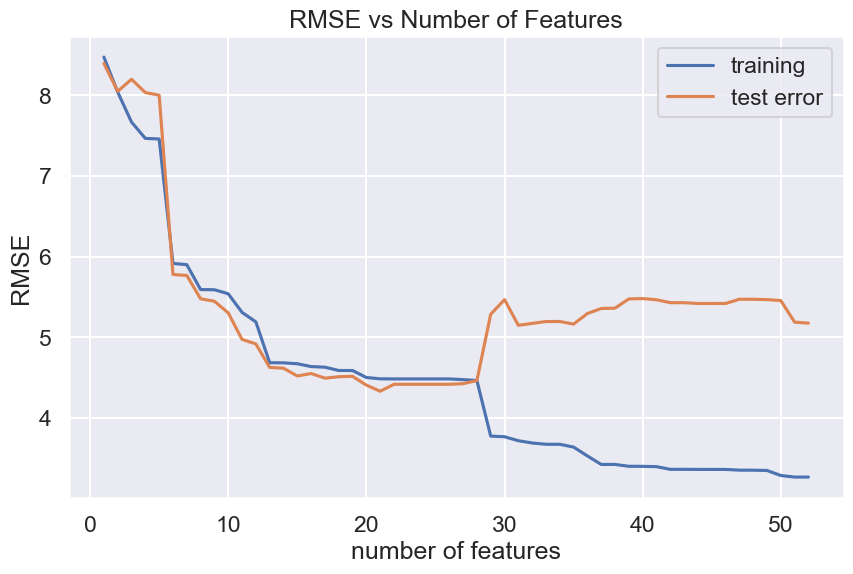

In [59]:
train_error_vs_N = []
test_error_vs_N = []

range_of_num_features = range(1, X_train2.shape[1] + 1)

for N in range_of_num_features:
    X_train_first_N_features = X_train2.iloc[:, :N]    
    
    linear_model.fit(X_train_first_N_features, Y_train2)
    train_error_overfit = rmse(Y_train2, linear_model.predict(X_train_first_N_features))
    train_error_vs_N.append(train_error_overfit)
    
    X_test_first_N_features = X_test2.iloc[:, :N]
    test_error_overfit = rmse(Y_test2, linear_model.predict(X_test_first_N_features))    
    test_error_vs_N.append(test_error_overfit)
    
plt.figure(figsize=(10, 6))
plt.plot(range_of_num_features, train_error_vs_N)
plt.plot(range_of_num_features, test_error_vs_N)
plt.legend(["training", "test error"])
plt.title('RMSE vs Number of Features')
plt.xlabel("number of features")
plt.ylabel("RMSE");

## Cross Validation

To figure out which feature set to use, we can use cross validation. Since there are 52 features, in theory, we could consider $2^{52}$ different models. For the sake of simplicity, we'll consider only 52 models, where the $i$th model includes features 1 through $i$. For example, the 3rd model would include the first 3 features only ("CRIM", "ZN", and "INDUS").

While using fewer features may increase our training error, it may also decrease our test error and help prevent overfitting to the training set.

You might ask, why don't we just use the plot above to find $p$, the optimal number of features? In real life, you'd NEVER generate this plot. Using the test set more than once for any reason is not a good idea. Otherwise, you're effectively using the test data to fit your hyperparameters (in this case, N, the number of features).

In the next section, we'll instead use $k$-fold cross-validation to select the best subset of features for our model. Recall the approach looks something like:

<img src="cv.png" width=500px>

**Warning**: The above questions are to illustrate some general differences we can see between train set and test set and the phenomenon on overfitting, however, we **should not use the test set at all when selecting models**. Instead, we should use cross-validation to select the feature set. When selecting features or choosing hyper-parameters, we can split the training set further into multiple train and validation sets (each split is called a "fold", hence k-fold cross validation). We will use the average validation error across all k folds to help select the optimal hyper-parameters and feature set.

**Furthermore,** selecting the first $N$ features, in general, is not a good way to select features, since the order of our columns is relatively meaningless. We present this as an example for you here to illustrate the concept of cross validation. In future assignments, we will look at more robust methods for feature selection.

### Question 4

Scikit-learn has built-in support for cross validation.  However, to better understand how cross validation works complete the following function which cross validates a given model.

1. Use the [`KFold.split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) function to get 4 splits on the training data. Note that `split` returns the indices of the data for that split.
2. For **each** split:
    1. Select out the training and validation rows and columns based on the split indices and features.
    2. Compute the RMSE on the validation split.
    3. Return the average error across all cross validation splits.

<!--
BEGIN QUESTION
name: q4
-->

In [61]:
from sklearn.model_selection import KFold

def compute_CV_error(model, X_train, Y_train):
    '''
    Split the training data into 4 subsets.
    For each subset, 
        fit a model holding out that subset
        compute the MSE on that subset (the validation set)
    You should be fitting 4 models total.
    Return the average MSE of these 4 folds.

    Args:
        model: an sklearn model with fit and predict functions 
        X_train (data_frame): Training data
        Y_train (data_frame): Label 

    Return:
        the average validation MSE for the 4 splits.
    '''
    kf = KFold(n_splits=4)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # split the data
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        
        # Compute the RMSE on the validation split
        y_pred = model.predict(split_X_valid)
        error = np.sqrt(np.mean((split_Y_valid - y_pred)**2))


        validation_errors.append(error)
        
    return np.mean(validation_errors)

compute_CV_error(lm.LinearRegression(),X_train2,Y_train2)

40.20940627376948

### Question 5

Use `compute_CV_error` to determine how many of the first $N$ features we should use to get the lowest average validation error. Then, fill in the variables `best_num_features`, `best_err`.

**Hint:** To find the index of the lowest error in `errors`, you may want to use [`np.argmin`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmin.html). Watch out for off by one issues when converting the index to the number of features!

<!--
BEGIN QUESTION
name: q5
-->

In [64]:
errors = []
for N in range_of_num_features:
    print(f"Trying first {N} features")
    model = lm.LinearRegression()
    
    # compute the cross validation error
    error = ...
    
    print("\tRMSE:", error)
    errors.append(error)

best_num_features = ...
best_err = ...

print(f"Best choice, use the first {best_num_features} features")

Trying first 1 features
	RMSE: 8.50141703201028
Trying first 2 features
	RMSE: 8.02461110914511
Trying first 3 features
	RMSE: 7.57594340081235
Trying first 4 features
	RMSE: 7.34628613602405
Trying first 5 features
	RMSE: 7.350601376553078
Trying first 6 features
	RMSE: 5.711968973675292
Trying first 7 features
	RMSE: 5.691948235815566
Trying first 8 features
	RMSE: 5.3792387543303954
Trying first 9 features
	RMSE: 5.385849171657425
Trying first 10 features
	RMSE: 5.329588255029874
Trying first 11 features
	RMSE: 5.079299451034964
Trying first 12 features
	RMSE: 4.9520289338802765
Trying first 13 features
	RMSE: 4.697093159561415
Trying first 14 features
	RMSE: 4.697093159561415
Trying first 15 features
	RMSE: 4.697093159561415
Trying first 16 features
	RMSE: 4.697093159561415
Trying first 17 features
	RMSE: 4.697093159561415
Trying first 18 features
	RMSE: 4.697093159561415
Trying first 19 features
	RMSE: 4.697093159561415
Trying first 20 features
	RMSE: 4.697093159561415
Trying firs

Why is it logical to use the set of features that result in the smallest average root mean squared error when performing cross-validation? Write your answer in the cell below.

_Type your answer here, replacing this text._

### Question 6

Finally, fit a linear model using your best feature set and predict housing prices for your original test set. You can also try to select your own features (on top of the given ones) to lower the RMSE. Compute the final train and test RMSEs for a linear model using your best feature set.

<!--
BEGIN QUESTION
name: q6
-->

In [ ]:
# Fit your linear model
model = ...

# Predict points from our test set and calculate the rmse
train_rmse = ... 
test_rmse = ...

print("Train RMSE", train_rmse)
print("KFold Validation RMSE", best_err)
print("Test RMSE", test_rmse)

: 

Here we've plotted a residual plot for each record from `X_test2`. After seeing your testing and training error, it is often helpful to visiualize your error. When points in the residual plot are randomly scattered around the line y = 0, then we know that a linear regression model is good for the data we have.

In [ ]:
plt.figure(figsize=(10, 6))
fitted_values = model.predict(X_test2.iloc[:, :best_num_features])
plt.scatter(fitted_values, Y_test2 - fitted_values)
plt.xlabel('Fitted Values')
plt.ylabel('residual (true y - estimated y)')
plt.title("Residual of prediction for i'th house")
plt.axhline(y = 0, color='r');

: 

Nice! You've used $k$-fold cross-validation to fit a linear regression model to the housing data.

In the future, you'd probably want to use something like [`cross_val_predict`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) to automatically perform cross-validation, but it's instructive to do it yourself at least once.

## Submission

To submit your assignment, please download your notebook as a .ipynb file and submit to Canvas. You can do so by navigating to the toolbar at the top of this page, clicking File > Download as... > Notebook (.ipynb) or HTML (.html). Then, upload both files under "Lab #08".